In [2]:
import duckdb as db
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def sql(query, database = "../data/database.duckdb"):
    con = db.connect(database)
    res = con.execute(query).df()
    con.close()
    return res

In [4]:
df = pd.DataFrame(sql(
    """  
    SELECT 
    startYear,
    runtimeMinutes
    FROM title_basics
    ORDER BY startYear 
    """
))

In [5]:
df = df[df['runtimeMinutes'].str.isnumeric()]
df = df[df['startYear'].str.isnumeric()]
df['runtimeMinutes'] = df['runtimeMinutes'].astype(int)
df['decade'] = df['startYear'].map(lambda x : (int(x)//10)*10)
df.groupby('decade')['runtimeMinutes'].mean().reset_index()


,decade,runtimeMinutes
0,1890,85.250000
1,1900,68.333333
2,1910,61.614941
3,1920,71.599322
4,1930,80.323367
5,1940,85.817381
6,1950,90.329973
7,1960,92.842161
8,1970,90.479730
9,1980,91.734226


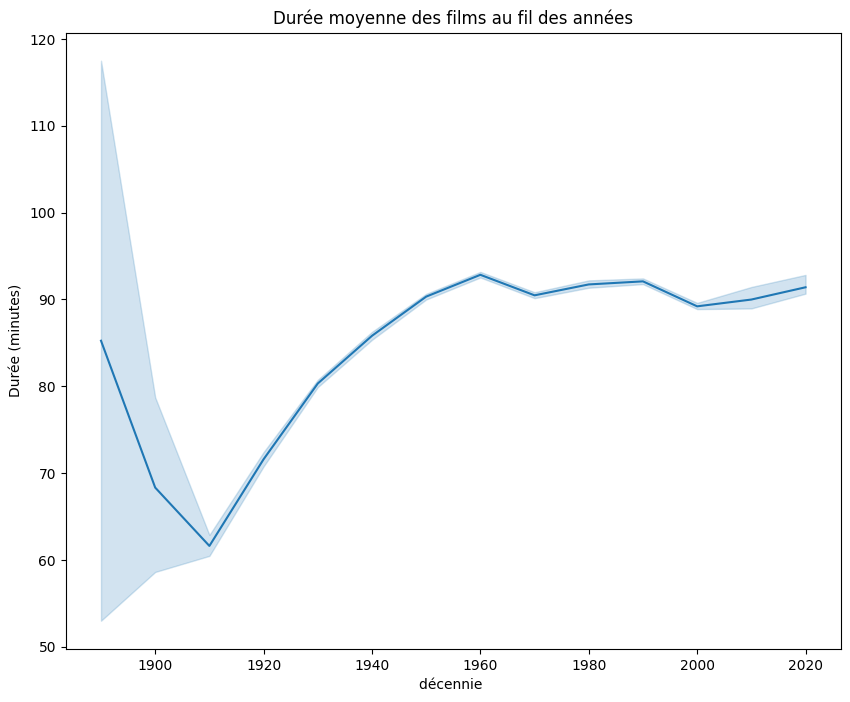

In [6]:
plt.figure(figsize=(10,8))
sns.lineplot(
    data=df,
    x= 'decade',
    y='runtimeMinutes'
)
plt.title('Durée moyenne des films au fil des années')
plt.ylabel('Durée (minutes)')
plt.xlabel('décennie ')
plt.savefig('../visuals/duree_moyenne_films.png')
plt.show()

In [13]:
sql(
    """  
    SELECT
    *
    FROM name_basics
    where birthYear not like '\\N'
    limit 10
    """
)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0027125,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
5,nm0000006,Ingrid Bergman,1915,1982,"actress,producer,soundtrack","tt0034583,tt0038109,tt0036855,tt0038787"
6,nm0000007,Humphrey Bogart,1899,1957,"actor,producer,miscellaneous","tt0034583,tt0043265,tt0033870,tt0037382"
7,nm0000008,Marlon Brando,1924,2004,"actor,director,writer","tt0078788,tt0068646,tt0047296,tt0070849"
8,nm0000009,Richard Burton,1925,1984,"actor,producer,director","tt0061184,tt0087803,tt0059749,tt0057877"
9,nm0000010,James Cagney,1899,1986,"actor,director,producer","tt0029870,tt0031867,tt0042041,tt0034236"


In [ ]:
sql(
    """  
    Select
    *
    from 
    """
)